In [1]:
! pip install pywph==1.0

Reason for being yanked: Wrong requirements.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pywph as pw
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
import time
import scipy.optimize as opt

In [3]:
# importing files from google drive
from google.colab import drive
drive.mount('/content/drive')

nbody = np.load('drive/MyDrive/camels data/Maps_Mtot_Nbody_SIMBA_LH_z=0.00.npy')
mstar = np.load('drive/MyDrive/camels data/Maps_Mstar_SIMBA_LH_z=0.00.npy')

Mounted at /content/drive


In [4]:
M, N = 256, 256
J = 7
L = 8
dn = 0

nbody_data = np.log(np.copy(nbody[0]))

In [5]:
mstar_data = np.copy(mstar[0])
mstar_data += 0.1
mstar_data = np.log(mstar_data)

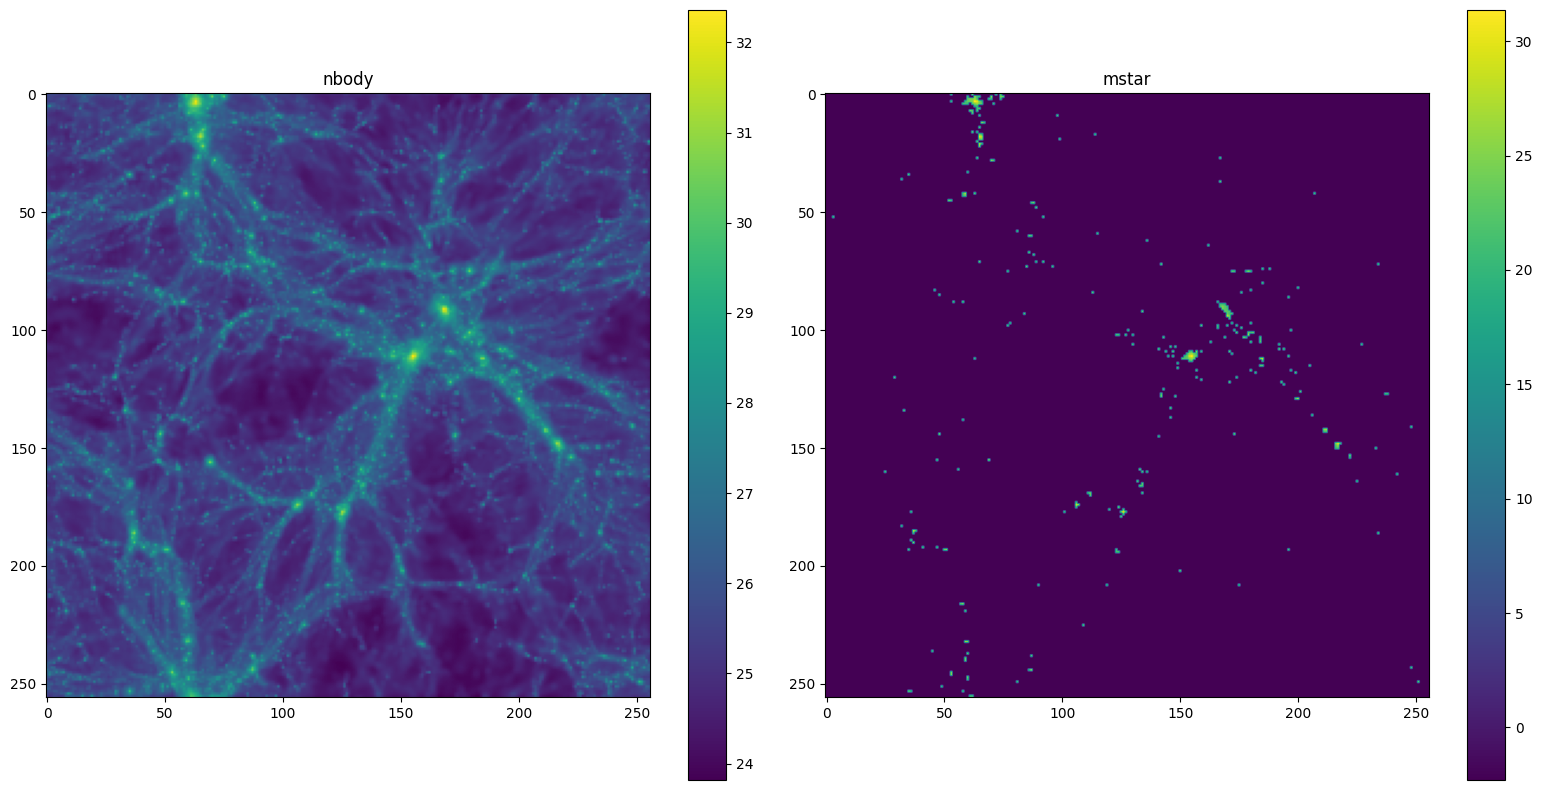

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0].set_title('nbody')
axs[1].set_title('mstar')

a1 = axs[0].imshow(nbody_data)
fig.colorbar(a1)
a2 = axs[1].imshow(mstar_data)
fig.colorbar(a2)

fig.tight_layout()
fig.show()

In [7]:
wph_op = pw.WPHOp(M, N, J, L=L, dn=dn, device=0) # operator
wph_op.load_model(cross_moments=True)

# get joint coefficients
norm = 'auto'
coeff1 = wph_op(nbody_data, norm=norm, pbc=True)
coeff2 = wph_op(mstar_data, norm=norm, pbc=True)
coeff12 = wph_op([nbody_data, mstar_data], cross=True, norm=norm, pbc=True)
coeff21 = wph_op([mstar_data, nbody_data], cross=True, norm=norm, pbc=True)
print(coeff1.shape)

/usr/local/lib/python3.10/dist-packages/pywph/wph_operator.py:774: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:276.)
  xpsi1_k1 -= mean1.to(xpsi1_k1.dtype) # Consistent dtype needed


torch.Size([3264])


In [8]:
# run on a GPU device
if torch.cuda.is_available():
    wph_op.to(0)

In [9]:
# generate a noise image as an initial guess
# guess = np.random.normal(nbody_data.mean(), nbody_data.std(), (2, M, N))
g1 = np.random.normal(nbody_data.mean(), nbody_data.std(), (M, N))
g2 = np.random.normal(mstar_data.mean(), mstar_data.std(), (M, N))
guess = np.array([g1,g2])
print(guess.shape)

(2, 256, 256)


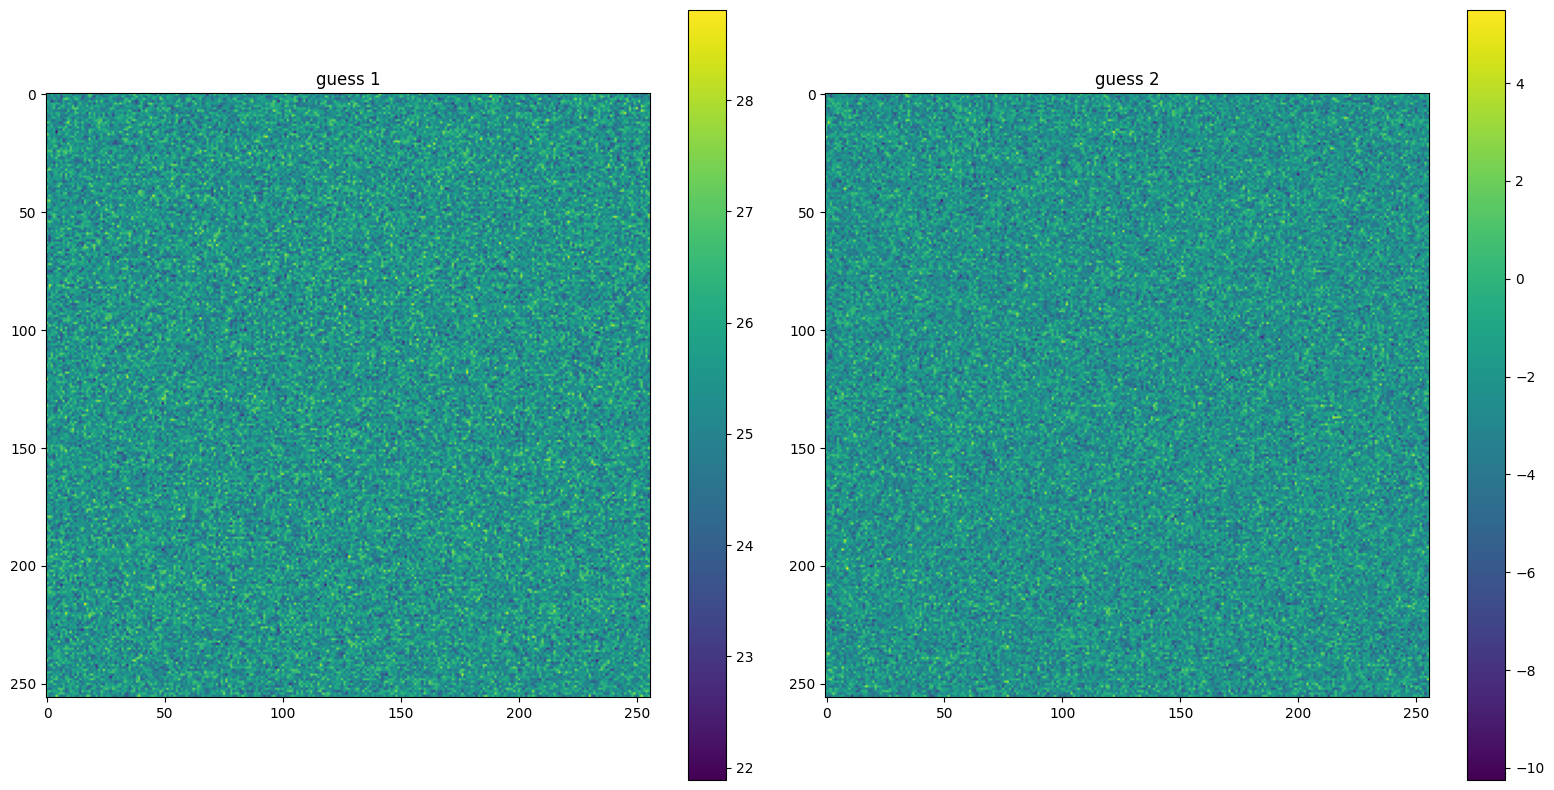

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].set_title('guess 1')
axs[1].set_title('guess 2')

a1 = axs[0].imshow(g1)
fig.colorbar(a1)
a2 = axs[1].imshow(g2)
fig.colorbar(a2)

fig.tight_layout()
fig.show()

In [11]:
# optimizer
device = 0
eval_cnt = 0
def objective1(x):

    global eval_cnt
    print(f"Evaluation: {eval_cnt}")
    start_time = time.time()
    # Reshape x
    x_curr = x.reshape((2, M, N))
    x_curr = pw.to_torch(x_curr, device=device)
    x_curr.requires_grad = True
    x_curr1 = x_curr[0]
    x_curr2 = x_curr[1]

    # Compute the loss (squared 2-norm)
    loss_tot = torch.zeros(1)

    x_curr1, nb_chunks = wph_op.preconfigure(x_curr1)
    for i in range(nb_chunks):
        coeffs_chunk, indices = wph_op.apply(x_curr1, i, norm=norm, ret_indices=True)
        loss = torch.sum(torch.abs(coeffs_chunk - coeff1[indices]) ** 2)
        loss.backward(retain_graph=True)
        loss_tot += loss.detach().cpu()
        del coeffs_chunk, indices, loss

    # Reshape the gradient
    x_grad = x_curr.grad.cpu().numpy().astype(x.dtype)
    print(f"Loss: {loss_tot.item()} (computed in {time.time() - start_time}s)")
    eval_cnt += 1

    return loss_tot.item(), x_grad.ravel()

In [12]:
eval_cnt = 0
def objective2(x):

    global eval_cnt
    print(f"Evaluation: {eval_cnt}")
    start_time = time.time()
    # Reshape x
    x_curr = x.reshape((2, M, N))
    x_curr = pw.to_torch(x_curr, device=device)
    x_curr.requires_grad = True
    x_curr1 = x_curr[0]
    x_curr2 = x_curr[1]

    # Compute the loss (squared 2-norm)
    loss_tot = torch.zeros(1)

    x_curr2, nb_chunks = wph_op.preconfigure(x_curr2)
    for i in range(nb_chunks):
        coeffs_chunk, indices = wph_op.apply(x_curr2, i, norm=norm, ret_indices=True)
        loss = torch.sum(torch.abs(coeffs_chunk - coeff2[indices]) ** 2)
        loss.backward(retain_graph=True)
        loss_tot += loss.detach().cpu()
        del coeffs_chunk, indices, loss

    # Reshape the gradient
    x_grad = x_curr.grad.cpu().numpy().astype(x.dtype)
    print(f"Loss: {loss_tot.item()} (computed in {time.time() - start_time}s)")
    eval_cnt += 1

    return loss_tot.item(), x_grad.ravel()

In [13]:
eval_cnt = 0
def objective3(x):

    global eval_cnt
    print(f"Evaluation: {eval_cnt}")
    start_time = time.time()
    # Reshape x
    x_curr = x.reshape((2, M, N))
    x_curr = pw.to_torch(x_curr, device=device)
    x_curr.requires_grad = True
    x_curr1 = x_curr[0]
    x_curr2 = x_curr[1]

    # Compute the loss (squared 2-norm)
    loss_tot = torch.zeros(1)
    x_curr_couple12, nb_chunks = wph_op.preconfigure([x_curr1, x_curr2], cross=True)
    for i in range(nb_chunks):
        coeffs_chunk12, indices = wph_op.apply(x_curr_couple12, i, norm=norm, ret_indices=True, cross=True)
        loss = torch.sum(torch.abs(coeffs_chunk12 - coeff12[indices]) ** 2)
        loss.backward(retain_graph=True)
        loss_tot += loss.detach().cpu()
        del coeffs_chunk12, indices, loss

    x_curr_couple21, nb_chunks = wph_op.preconfigure([x_curr2, x_curr1], cross=True)
    for i in range(nb_chunks):
        coeffs_chunk21, indices = wph_op.apply(x_curr_couple21, i, norm=norm, ret_indices=True, cross=True)
        loss = torch.sum(torch.abs(coeffs_chunk21 - coeff21[indices]) ** 2)
        loss.backward(retain_graph=True)
        loss_tot += loss.detach().cpu()
        del coeffs_chunk21, indices, loss

    # Reshape the gradient
    x_grad = x_curr.grad.cpu().numpy().astype(x.dtype)
    print(f"Loss: {loss_tot.item()} (computed in {time.time() - start_time}s)")
    eval_cnt += 1

    return loss_tot.item(), x_grad.ravel()

In [14]:
total_start_time = time.time()
optim_params = {"maxiter": 100, "gtol": 1e-14, "ftol": 1e-14, "maxcor": 20}
result = opt.minimize(objective1, guess.ravel(), method='L-BFGS-B', jac=True, tol=None, options=optim_params)
final_loss, x_final, niter, msg = result['fun'], result['x'], result['nit'], result['message']
print(f"Synthesis ended in {niter} iterations with optimizer message: {msg}")
print(f"Synthesis time: {time.time() - total_start_time}s")

x_final = x_final.reshape((2, M, N)).astype(np.float32)

Evaluation: 0
Loss: 2284.369140625 (computed in 1.3079249858856201s)
Evaluation: 1
Loss: 2240.451904296875 (computed in 0.8494269847869873s)
Evaluation: 2
Loss: 2067.33642578125 (computed in 0.8445236682891846s)
Evaluation: 3
Loss: 1478.5462646484375 (computed in 0.8507304191589355s)
Evaluation: 4
Loss: 290.28985595703125 (computed in 0.8724868297576904s)
Evaluation: 5
Loss: 212.47145080566406 (computed in 0.8523173332214355s)
Evaluation: 6
Loss: 155.03726196289062 (computed in 0.8598461151123047s)
Evaluation: 7
Loss: 109.16004180908203 (computed in 0.845954179763794s)
Evaluation: 8
Loss: 152.7913360595703 (computed in 0.8438870906829834s)
Evaluation: 9
Loss: 64.04969024658203 (computed in 0.8497052192687988s)
Evaluation: 10
Loss: 59.92295837402344 (computed in 0.8611533641815186s)
Evaluation: 11
Loss: 46.690059661865234 (computed in 0.8603377342224121s)
Evaluation: 12
Loss: 31.363563537597656 (computed in 0.8593020439147949s)
Evaluation: 13
Loss: 18.115652084350586 (computed in 0.8472

In [15]:
total_start_time = time.time()
result = opt.minimize(objective2, x_final.ravel(), method='L-BFGS-B', jac=True, tol=None, options=optim_params)
final_loss, x_final, niter, msg = result['fun'], result['x'], result['nit'], result['message']
print(f"Synthesis ended in {niter} iterations with optimizer message: {msg}")
print(f"Synthesis time: {time.time() - total_start_time}s")

x_final = x_final.reshape((2, M, N)).astype(np.float32)

Evaluation: 105
Loss: 4.757247510970368e+16 (computed in 0.8432755470275879s)
Evaluation: 106
Loss: 1.7345835310252032e+17 (computed in 0.8502185344696045s)
Evaluation: 107
Loss: 30349929218048.0 (computed in 0.8463096618652344s)
Evaluation: 108
Loss: 30214352535552.0 (computed in 0.8479931354522705s)
Evaluation: 109
Loss: 30214685982720.0 (computed in 0.8471834659576416s)
Evaluation: 110
Loss: 30201801080832.0 (computed in 0.8452339172363281s)
Evaluation: 111
Loss: 30214685982720.0 (computed in 0.8463385105133057s)
Evaluation: 112
Loss: 30201801080832.0 (computed in 0.8492774963378906s)
Evaluation: 113
Loss: 30201801080832.0 (computed in 0.8540341854095459s)
Evaluation: 114
Loss: 30201801080832.0 (computed in 0.8474326133728027s)
Evaluation: 115
Loss: 30201801080832.0 (computed in 0.8501219749450684s)
Evaluation: 116
Loss: 30201801080832.0 (computed in 0.8475353717803955s)
Evaluation: 117
Loss: 30201801080832.0 (computed in 0.8486316204071045s)
Evaluation: 118
Loss: 30201801080832.0 (

In [16]:
total_start_time = time.time()
result = opt.minimize(objective3, x_final.ravel(), method='L-BFGS-B', jac=True, tol=None, options=optim_params)
final_loss, x_final, niter, msg = result['fun'], result['x'], result['nit'], result['message']
print(f"Synthesis ended in {niter} iterations with optimizer message: {msg}")
print(f"Synthesis time: {time.time() - total_start_time}s")

x_final = x_final.reshape((2, M, N)).astype(np.float32)

Evaluation: 133
Loss: 1.4972345384151338e+20 (computed in 1.7050857543945312s)
Evaluation: 134
Loss: 1.438338274483545e+20 (computed in 1.7073688507080078s)
Evaluation: 135
Loss: 1.3323209004273369e+20 (computed in 1.7071127891540527s)
Evaluation: 136
Loss: 5.065582890168667e+19 (computed in 1.7104802131652832s)
Evaluation: 137
Loss: 8.30585872053384e+18 (computed in 1.7120497226715088s)
Evaluation: 138
Loss: 4.0301217454646886e+17 (computed in 1.711061716079712s)
Evaluation: 139
Loss: 3444630343385088.0 (computed in 1.7061455249786377s)
Evaluation: 140
Loss: 2594663038976.0 (computed in 1.71779465675354s)
Evaluation: 141
Loss: 1104178053120.0 (computed in 1.705559253692627s)
Evaluation: 142
Loss: 1103380873216.0 (computed in 1.7034037113189697s)
Evaluation: 143
Loss: 1103347580928.0 (computed in 1.7050795555114746s)
Evaluation: 144
Loss: 1104173072384.0 (computed in 1.7083055973052979s)
Evaluation: 145
Loss: 1103380873216.0 (computed in 1.7059085369110107s)
Evaluation: 146
Loss: 11033

In [17]:
final_guess = x_final
sim1 = final_guess[0]
sim2 = final_guess[1]

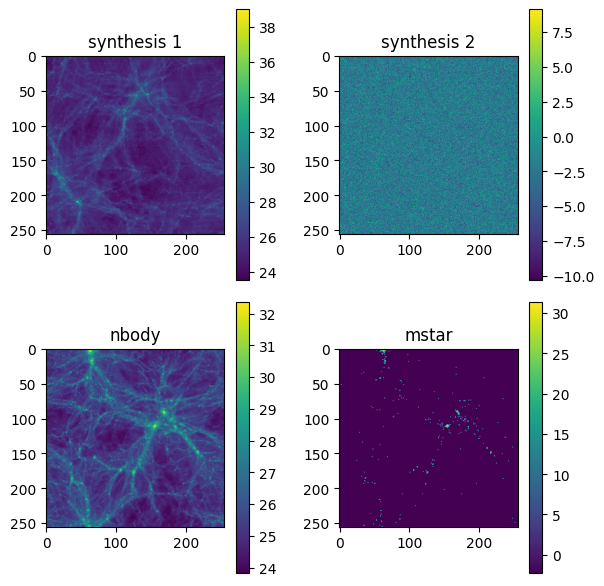

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

axs[0,0].imshow(sim1)
axs[0,1].imshow(sim2)
axs[1,0].imshow(nbody_data)
axs[1,1].imshow(mstar_data)

axs[0,0].set_title('synthesis 1')
axs[0,1].set_title('synthesis 2')
axs[1,0].set_title('nbody')
axs[1,1].set_title('mstar')#######('mgas')

a1 = axs[0,0].imshow(sim1)
fig.colorbar(a1)
a2 = axs[0,1].imshow(sim2)
fig.colorbar(a2)
a3 = axs[1,0].imshow(nbody_data)
fig.colorbar(a3)
a4 = axs[1,1].imshow(mstar_data)
fig.colorbar(a4)
fig.tight_layout()
fig.show()

In [19]:
wph1 = wph_op(sim1, ret_wph_obj=True) # WPH object
s11_guess_1 = wph1.get_coeffs("S11")[0]
wph2 = wph_op(sim2, ret_wph_obj=True)
s11_guess_2 = wph2.get_coeffs("S11")[0]

wph_nbody = wph_op(nbody_data, ret_wph_obj=True)
s11_guess_nbody = wph_nbody.get_coeffs("S11")[0]

wph_mstar = wph_op(mstar_data, ret_wph_obj=True)
s11_guess_mstar = wph_mstar.get_coeffs("S11")[0]

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


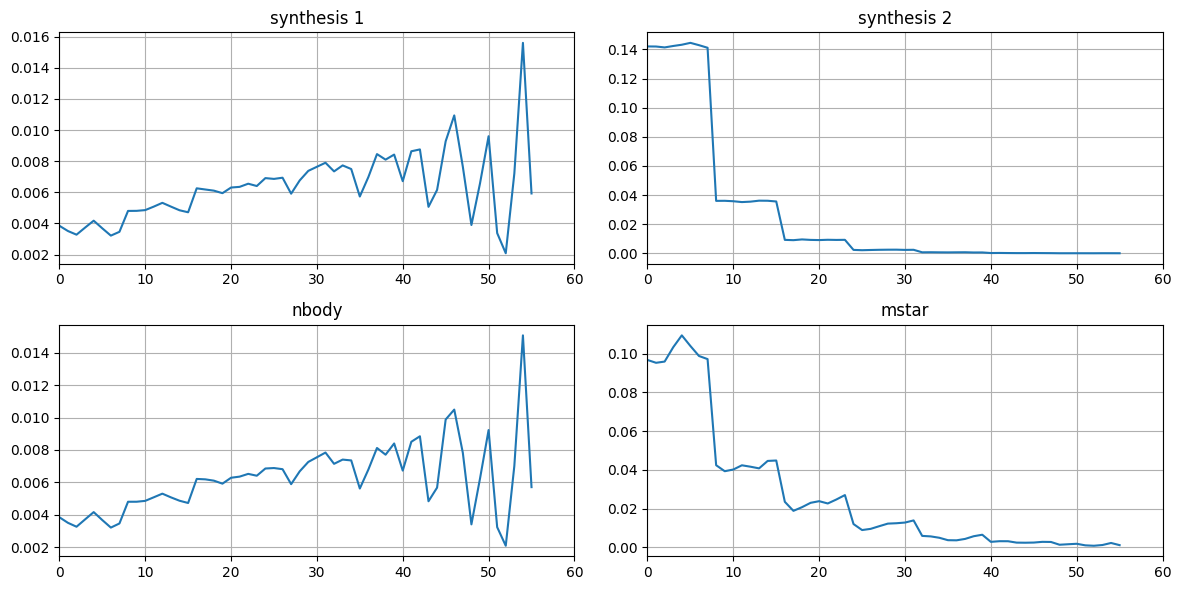

In [20]:
# compare S11 coefficients
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

axs[0,0].plot(s11_guess_1)
axs[0,1].plot(s11_guess_2)
axs[1,0].plot(s11_guess_nbody)
axs[1,1].plot(s11_guess_mstar)

axs[0,0].set_title('synthesis 1')
axs[0,1].set_title('synthesis 2')
axs[1,0].set_title('nbody')
axs[1,1].set_title('mstar')

for i in range(2):
    for j in range(2):
      axs[i,j].set_xlim(0,60)
      #axs[i,j].set_ylim(0,0.018)
      axs[i,j].grid()


fig.tight_layout()
fig.show()

In [21]:
wph1 = wph_op(sim1, ret_wph_obj=True) # WPH object
s10_guess_1 = wph1.get_coeffs("S10")[0]
wph2 = wph_op(sim2, ret_wph_obj=True)
s10_guess_2 = wph2.get_coeffs("S10")[0]

wph_nbody = wph_op(nbody_data, ret_wph_obj=True)
s10_guess_nbody = wph_nbody.get_coeffs("S10")[0]

wph_mstar = wph_op(mstar_data, ret_wph_obj=True)
s10_guess_mstar = wph_mstar.get_coeffs("S10")[0]

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


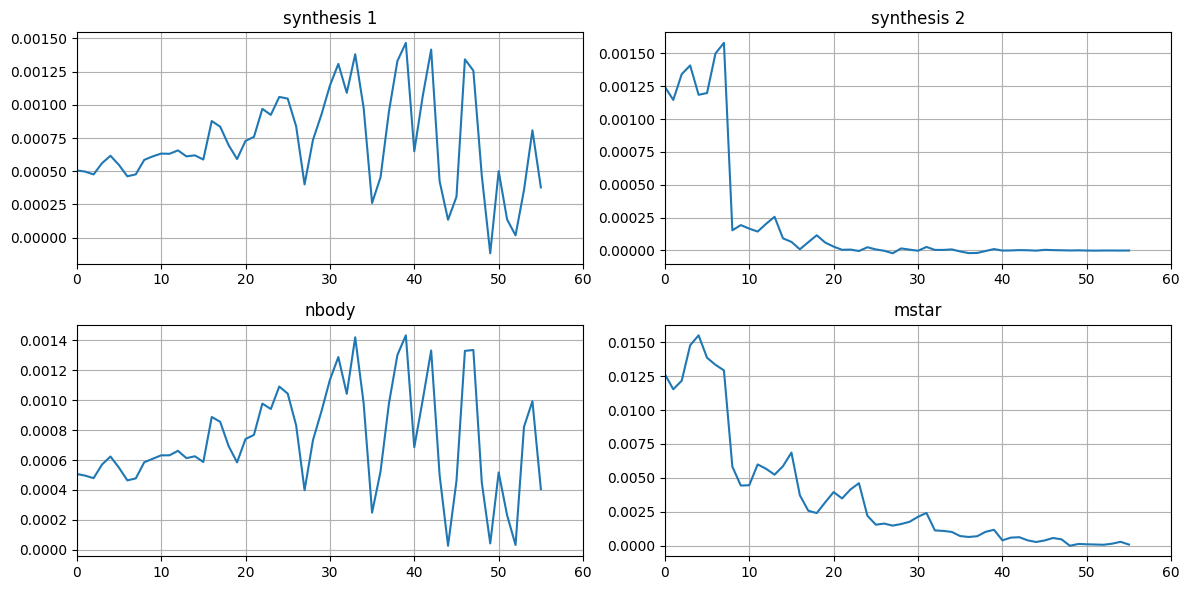

In [22]:
# compare S10 coefficients
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

axs[0,0].plot(s10_guess_1)
axs[0,1].plot(s10_guess_2)
axs[1,0].plot(s10_guess_nbody)
axs[1,1].plot(s10_guess_mstar)

axs[0,0].set_title('synthesis 1')
axs[0,1].set_title('synthesis 2')
axs[1,0].set_title('nbody')
axs[1,1].set_title('mstar')

for i in range(2):
    for j in range(2):
      axs[i,j].set_xlim(0,60)
      #axs[i,j].set_ylim(0,0.0017)
      axs[i,j].grid()


fig.tight_layout()
fig.show()